## Plots and analysis for the final Report

In [1]:
from __future__ import print_function, division
import sys
sys.path.append('../src')
sys.path.append('../script')
import numpy as np
import time
import torch
import pickle
# from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from data_classes import RNASeqDataset, LocalEnergy
from my_script2 import get_target, loss_fn, train, test
from sklearn import decomposition, manifold
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from matplotlib import rc
import seaborn as sns

plt.style.use('default')
plt.rcParams["font.family"] = "serif"
rc('text.latex', preamble=r'\usepackage{cmbright}')

## Loss function and batch size

In [2]:
# Datasets and Dataloaders
dataset = RNASeqDataset()

tot_length = len(dataset)
test_length = int(0.2*tot_length)
train_set, test_set = random_split(dataset, [tot_length - test_length, test_length], generator=torch.Generator().manual_seed(42))
print(f'Training set: {len(train_set)} elements')
print(f'Test set: {len(test_set)} elements')

Training set: 1308 elements
Test set: 327 elements


In [3]:
model = LocalEnergy()
model.load_state_dict(torch.load('../results/NewResults/initial_values.pth'))

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
my_loss = loss_fn  # _with_grad
my_train = train  # _with_grad
my_test = test  # _with_grad

params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': True,
          'pin_memory': False}
epochs = 50
train_dataloader = DataLoader(train_set,**params)
test_dataloader = DataLoader(test_set,**params)

In [ ]:
batch_size_list = [1,4,16,64,256]
all_times = []
all_train_loss = []
all_test_loss = []
epochs = 50
for batch_size in batch_size_list:
    print('batch size = %i' %batch_size)
    params['batch_size'] = batch_size
    print(params)
    train_dataloader = DataLoader(train_set,**params)
    test_dataloader = DataLoader(test_set,**params)
    model.load_state_dict(torch.load("../results/NewResults/initial_values.pth"))
    times = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        t0 = time.time()
        print(f'epoch {i+1}/{epochs} \n-------------------------')
        train_tmp = my_train(train_dataloader, model, my_loss, optimizer)
        test_tmp = my_test(test_dataloader, model, my_loss)        
        tf = time.time()
        times.append(tf-t0)
        train_loss.append(train_tmp)
        test_loss.append(test_tmp)
    all_times.append(times)
    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    
all_times = np.array(all_times)
all_train_loss = np.array(all_train_loss)
all_test_loss = np.array(all_test_loss)

print(all_times.shape)
print(all_train_loss.shape)
print(all_test_loss.shape)

np.save('times.npy', all_times)
np.save('batch_loss.npy', all_train_loss)

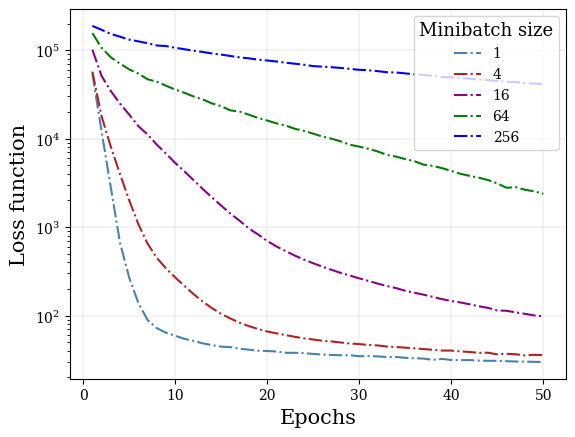

In [34]:
all_times = np.load('../results/NpyFiles/times.npy')
all_train_loss = np.load('../results/NpyFiles/batch_loss.npy')


# from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

# print(all_train_loss)
x = np.arange(1,epochs+1)
plt.plot(x,all_train_loss[0], '-.', label='1', color = 'steelblue') #color = 'steelblue')
plt.plot(x,all_train_loss[1], '-.', label='4', color = 'firebrick') #'steelblue')
plt.plot(x,all_train_loss[2], '-.', label='16', color = 'darkmagenta') #'steelblue')
plt.plot(x,all_train_loss[3], linestyle='-.', label='64', color = 'green') #'steelblue')
plt.plot(x,all_train_loss[4], '-.', label='256', color = 'b') #'steelblue')
plt.yscale('log')
plt.grid(linewidth=0.2)
plt.legend(title='Minibatch size',fontsize=13,title_fontsize=13, prop={"family":"serif"})
plt.xlabel('Epochs',fontsize=15, fontname = 'serif')
plt.ylabel('Loss function',fontsize=15, fontname = 'serif')
plt.grid(linewidth=0.2)
plt.savefig('../Images/batch_loss.png', bbox_inches='tight',dpi=100)

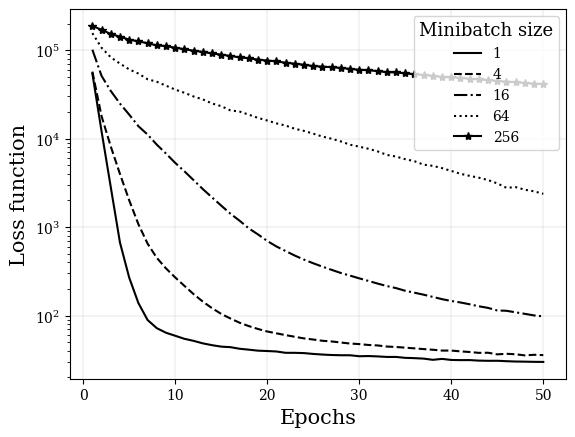

In [10]:
x = np.arange(1,epochs+1)
plt.plot(x,all_train_loss[0], '-', label='1', color = 'black') #color = 'steelblue')
plt.plot(x,all_train_loss[1], '--', label='4', color = 'black') #'steelblue')
plt.plot(x,all_train_loss[2], '-.', label='16', color = 'black') #'steelblue')
plt.plot(x,all_train_loss[3], linestyle='dotted', label='64', color = 'black') #'steelblue')
plt.plot(x,all_train_loss[4], '-*', label='256', color = 'black') #'steelblue')
plt.yscale('log')
plt.grid(linewidth=0.2)
plt.legend(title='Minibatch size',fontsize=13,title_fontsize=13, prop={"family":"serif"})
plt.xlabel('Epochs',fontsize=15, fontname = 'serif')
plt.ylabel('Loss function',fontsize=15, fontname = 'serif')
plt.grid(linewidth=0.2)
plt.savefig('../Images/batch_loss.pdf', bbox_inches='tight')

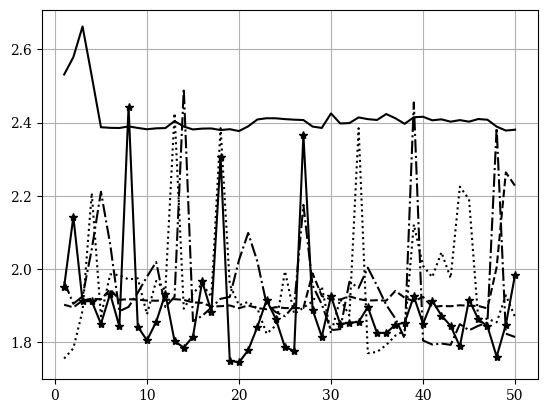

In [8]:
plt.plot(x,all_times[0], '-', label='1', color = 'black') #color = 'steelblue')
plt.plot(x,all_times[1], '--', label='4', color = 'black') #'steelblue')
plt.plot(x,all_times[2], '-.', label='16', color = 'black') #'steelblue')
plt.plot(x,all_times[3], linestyle='dotted', label='64', color = 'black') #'steelblue')
plt.plot(x,all_times[4], '-*', label='256', color = 'black') #'steelblue')
plt.grid()

[0.05205005 0.06859435 0.15500816 0.1519809  0.1393522 ]


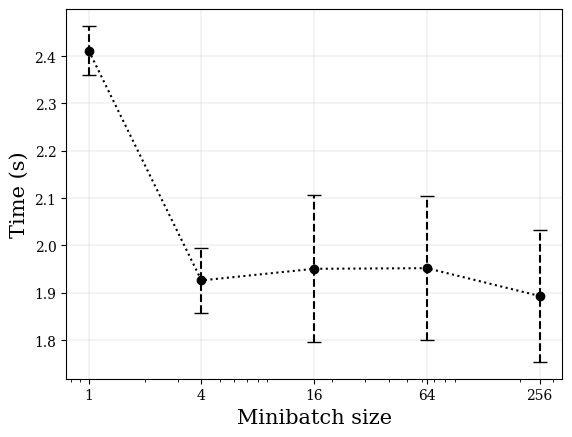

In [35]:
tmean = np.mean(all_times,axis=1)
tstd = np.var(all_times,axis=1)**0.5
print(tstd)
batch_size_list = [1,4,16,64,256]


p = plt.errorbar(batch_size_list,tmean,tstd,fmt='o',color='black',capsize=5, ls='dotted')
plt.xscale('log')
p[-1][0].set_linestyle('--')
plt.xlabel('Minibatch size', fontsize=15)
plt.ylabel('Time (s)', fontsize=15)
ax = plt.gca()
# set the positions where we want ticks to appear
ax.xaxis.set_ticks([1,4,16,64,256])
# set what will actually be displayed at each tick.
ax.xaxis.set_ticklabels([1,4,16,64,256])
plt.grid(linewidth=0.2)
plt.savefig('../Images/batch_time.png', bbox_inches='tight',dpi=100)

In [2]:
import seaborn as sns

def plot_hist(idx_dict,energies):
    fig,ax = plt.subplots(1,3,figsize=(18,5))
    for i in idx_dict.keys():
        hist1 = ax[i].hist(energies['amber'][i], bins=30, density=True, label='Amber')
        ax[i].hist(energies['hire'][i], bins=30, alpha=0.6, density=True, label='HiRE')
        ax[i].set_xlabel(idx_dict[i]+' energy', fontsize=15)
        ax[i].set_ylabel('Prob. distribution', fontsize=15)
        ax[i].set_title(idx_dict[i]+' energy distribution', fontsize=18)
        ax[i].legend(fontsize=15)
    return 0


def compare_energies(dataset,model,plot=False):
    
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = {'amber': [], 'hire': []}
    stats = {'amber': [], 'hire': []}
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        hire_en = np.array([model(dataset[j]).squeeze()[i].item() for j in range(len(dataset))])
        energies['amber'].append(amber_en)
        energies['hire'].append(hire_en)
        stats['amber'].append([amber_en.mean(), amber_en.var()])
        stats['hire'].append([hire_en.mean(), hire_en.var()])
        print(idx_dict[i]+' energy computed')
    stats['amber'] = np.array(stats['amber'])
    stats['hire'] = np.array(stats['hire'])
    
    if plot:
        plot_hist(idx_dict,energies)
        
    return energies,stats


def amber_dist(dataset):
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = []
    stats = []
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        energies.append(amber_en)
        stats.append([amber_en.mean(), amber_en.var()])
    fig,ax = plt.subplots(1,3,figsize=(18,5.5))
    for i in idx_dict.keys():
        if i == 0:
            hist1 = ax[i].hist(energies[i], bins = 50, density=True, color='steelblue', lw=0)
        else:
            hist1 = ax[i].hist(energies[i], bins = 25, density=True, color='steelblue', lw=0)
        ax[i].set_xlabel(idx_dict[i]+r' energy (kcal/mol)', fontsize=16, fontname='serif')
        ax[i].set_title(idx_dict[i]+' energy distribution', fontsize=18, fontname='serif')
        ax[i].grid(linewidth=0.2)
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (stats[i][0], ),
        r'$\sigma=%.2f$' % (stats[i][1]**0.5, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

        # place a text box in upper left in axes coords
        ax[i].text(0.65, 0.9, textstr, transform=ax[i].transAxes, fontsize=16,
                verticalalignment='top', bbox=props, fontname='serif')
        
    ax[0].set_ylabel('Prob. distribution', fontsize=16, fontname='serif')
    ax[0].set_xlim([5,30])
    plt.savefig('../Images/amber_histo.png', bbox_inches='tight')
    return energies,stats


def amber_dist_oneplot(dataset):
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = []
    stats = []
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        energies.append(amber_en)
        stats.append([amber_en.mean(), amber_en.var()])
    fig,axes = plt.subplots(1,3,figsize=(18,5.5))
    for i in idx_dict.keys():
        sns.distplot(ax = axes[i], x=energies[i], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3})
        axes[i].set_xlabel(idx_dict[i]+r' energy (kcal/mol)', fontsize=16, fontname='serif')
        axes[i].set_title(idx_dict[i]+' energy distribution', fontsize=18, fontname='serif')
        axes[i].grid(linewidth=0.2)
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (stats[i][0], ),
        r'$\sigma=%.2f$' % (stats[i][1]**0.5, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

        # place a text box in upper left in axes coords
        axes[i].text(0.65, 0.9, textstr, transform=axes[i].transAxes, fontsize=16,
                verticalalignment='top', bbox=props, fontname='serif')
        
    axes[0].set_ylabel('Prob. distribution', fontsize=16, fontname='serif')
    axes[0].set_xlim([5,30])
    plt.savefig('../Images/amber_dist.png', bbox_inches='tight')
    return energies,stats
    

In [18]:
from sklearn.metrics import r2_score

def train_score(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    y_true = torch.zeros((num_batches,3*dataloader.batch_size))
    y_pred = torch.zeros((num_batches,3*dataloader.batch_size))
    for i,X in enumerate(dataloader):
        pred = model(X)
        target = get_target(X)
        y_true[i] = target.reshape(-1,)  # requires drop_last = True
        y_pred[i] = pred.reshape(-1,)
        loss = loss_fn(pred, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    acc = r2_score(y_true,y_pred)
    train_loss /= num_batches
    print(f'Avg loss = {train_loss:>0.4f}, batches = {num_batches}')
    return train_loss, acc


def test_score(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    y_true = torch.zeros((num_batches,3*dataloader.batch_size))
    y_pred = torch.zeros((num_batches,3*dataloader.batch_size))
    with torch.no_grad():
        for i,X in enumerate(dataloader):
            pred = model(X)
            target = get_target(X)
            y_true[i] = target.reshape(-1,) # requires drop_last = True
            y_pred[i] = pred.reshape(-1,)
            loss = loss_fn(pred, target)
            test_loss += loss.item()
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    acc = r2_score(y_true,y_pred)
    test_loss /= num_batches
    print(f'Avg test_loss = {test_loss:>0.4f}, batches = {num_batches}')
    return test_loss, acc

In [23]:
model.load_state_dict(torch.load('../results/ResultsReport/400_b4_free_optimization.pth'))
for p in model.parameters():
    print(p.data)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
my_loss = loss_fn # _with_grad
my_train = train_score  # _with_grad
my_test = test_score  # _with_grad

params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': True,
          'pin_memory': False}
epochs = 400
train_dataloader = DataLoader(train_set,**params)
test_dataloader = DataLoader(test_set,**params)

tensor([2.5078e-01, 1.4221e+00, 9.5803e-01, 1.4372e+00, 3.1685e+00, 3.0414e+00,
        2.9399e+00, 4.3877e+00, 9.1363e-01, 1.4403e+00, 1.5223e+01, 1.0000e+00,
        2.8000e+00, 2.5050e+00, 1.8260e+00, 3.9320e+00, 4.3090e+00, 4.7750e+00,
        4.5460e+00, 2.8210e+00, 3.8130e+00, 3.0100e+00, 9.0800e-01, 3.0000e+00,
        4.0000e+00, 2.2570e+00, 4.8000e-01, 5.0000e-01, 4.8864e+00, 1.0707e+01,
        1.1320e+01, 4.7431e+00, 3.5133e-01, 6.2101e-01, 6.1727e-02, 8.3912e-01,
        7.6194e-01, 6.0133e-01, 1.2000e+00, 1.5000e+00, 4.0000e-01, 1.8000e+00,
        8.0000e-01, 1.4231e+02, 1.0000e+00, 0.0000e+00, 2.8619e-02])
tensor([ 26.4737, 198.3302, 199.8809, 199.2575, 199.5909, 199.9412, 200.0606,
        199.8165, 200.0325, 199.6405, 199.5755,  40.0000,  10.0000,  10.0000,
         10.0000])
tensor([ 69.5992,  69.4485,  69.5262,  69.6653, 119.7809, 119.4121,  69.1445,
         69.0051,  68.3617,  48.1406,  68.7695,  98.8524,  80.0000])
tensor([0.6600, 1.2392, 0.2688, 0.6788, 0.8360, 0

In [ ]:
train_loss = []
test_loss = []
train_score = []
test_score = []
for i in range(epochs):
    print(f'epoch {i+1}/{epochs} \n-------------------------')
    train_tmp, train_acc = my_train(train_dataloader, model, my_loss, optimizer)
    test_tmp, test_acc = my_test(test_dataloader, model, my_loss)        
    train_loss.append(train_tmp)
    test_loss.append(test_tmp)
    train_score.append(train_acc)
    test_score.append(test_acc)

np.save('../results/NpyFiles/train_loss2.npy', train_loss)
np.save('../results/NpyFiles/test_loss2.npy', test_loss)
np.save('../results/NpyFiles/train_score2.npy', train_score)
np.save('../results/NpyFiles/test_score2.npy', test_score)

torch.save(model.state_dict(), '../results/ResultsReport/800_b4_free_optimization.pth')

for p in model.parameters():
    print(p.data)

In [57]:
torch.save(model.state_dict(), '../results/ResultsReport/800_b4_free_optimization.pth')

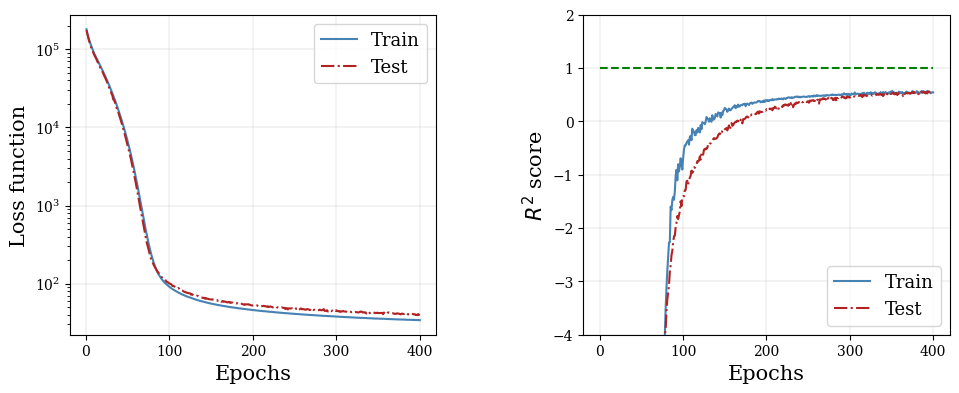

In [36]:
train_loss = np.load('../results/NpyFiles/train_loss.npy')
test_loss = np.load('../results/NpyFiles/test_loss.npy')
train_score = np.load('../results/NpyFiles/train_score.npy')
test_score = np.load('../results/NpyFiles/test_score.npy')

fig,axes = plt.subplots(1,2,figsize=(11,4))
x = np.arange(400)+1
axes[0].plot(x,train_loss,label='Train', color='steelblue')
axes[0].plot(x,test_loss,'-.',label='Test',color='firebrick')
axes[0].set_xlabel('Epochs', fontsize=15)
axes[0].set_ylabel('Loss function', fontsize=15)
axes[0].set_yscale('log')
axes[0].grid(linewidth=0.2)
axes[0].legend(fontsize=13)

axes[1].plot(x,train_score, label='Train', color='steelblue')
axes[1].plot(x,test_score, '-.', label='Test', color='firebrick')
axes[1].set_xlabel('Epochs', fontsize=15)
axes[1].set_ylabel(r'$R^2$ score', fontsize=15)
axes[1].set_ylim([-4,2])
axes[1].grid(linewidth=0.2)
axes[1].legend(fontsize=13,loc='lower right')
axes[1].hlines(y=1, color='g', linestyle='--', xmin=0, xmax=400)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.savefig('../Images/first_minimization_loss.png',bbox_inches='tight', dpi=100)

In [27]:
def plot_3hist(idx_dict,energies):
    fig,axes = plt.subplots(1,3,figsize=(18,6))
    for i in idx_dict.keys():
        sns.distplot(ax = axes[i], x=energies['amber'][i], hist = False, kde = True,
             kde_kws = {'shade': True, 'alpha':0.1, 'bw':0.2, 'linewidth': 3, 'linestyle':'--'},
                     label='Amber', color='firebrick')
        sns.distplot(ax = axes[i], x=energies['hire'][i], hist = False, kde = True,
             kde_kws = {'shade': True, 'alpha':0.3, 'bw':0.2, 'linewidth': 2}, label='HiRE old', color='darkmagenta')
        sns.distplot(ax = axes[i], x=energies['new'][i], hist = False, kde = True,
             kde_kws = {'shade': True, 'alpha':0.3, 'bw':0.2, 'linewidth': 2}, label='HiRE new', color='b')
        axes[i].set_xlabel(idx_dict[i]+r' energy (kcal/mol)', fontsize=20, fontname='serif')
        # axes[i].set_title(idx_dict[i]+' energy distribution', fontsize=18, fontname='serif')
        axes[i].grid(linewidth=0.3)
        axes[0].legend(fontsize=18)
        axes[i].tick_params(axis='both', which='major', labelsize=13)
        
    axes[0].set_ylabel('Prob. distribution', fontsize=20, fontname='serif')
    axes[0].set_xlim([0,50])
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    axes[1].set_xlim([0,100])
    
    plt.savefig('../Images/first_minimization_dist.png',bbox_inches='tight',dpi=100)
    return 


def compare_energies_for3(dataset,model1,model2,plot=False):
    
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = {'amber': [], 'hire': [], 'new': []}
    stats = {'amber': [], 'hire': [], 'new': []}
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        hire_en = np.array([model1(dataset[j]).squeeze()[i].item() for j in range(len(dataset))])
        new_en = np.array([model2(dataset[j]).squeeze()[i].item() for j in range(len(dataset))])
        energies['amber'].append(amber_en)
        energies['hire'].append(hire_en)
        energies['new'].append(new_en)
        stats['amber'].append([amber_en.mean(), amber_en.var()])
        stats['hire'].append([hire_en.mean(), hire_en.var()])
        stats['new'].append([new_en.mean(), new_en.var()])
        print(idx_dict[i]+' energy computed')
    stats['amber'] = np.array(stats['amber'])
    stats['hire'] = np.array(stats['hire'])
    stats['hnew'] = np.array(stats['new'])
    
    # if plot:
    #     plot_3hist(idx_dict,energies)
        
    return energies,stats

In [29]:
from data_classes import RNASeqDataset_old

model1 = LocalEnergy()
model2 = LocalEnergy()

model1.load_state_dict(torch.load('../results/NewResults/initial_values.pth'))
print(model1.state_dict())
model2.load_state_dict(torch.load('../results/ResultsReport/400_b4_free_optimization.pth'))

dataset = RNASeqDataset()
tot_length = len(dataset)
test_length = int(0.2*tot_length)
train_set, test_set = random_split(dataset, [tot_length - test_length, test_length], 
                                   generator=torch.Generator().manual_seed(42))
energies,_ = compare_energies_for3(test_set,model1,model2)

OrderedDict([('opt_pars', tensor([  2.6080,   2.0730,   1.5190,   2.3550,   4.1900,   4.6980,   4.8240,
          5.6360,   2.1300,   1.3070,  15.2230,   1.0000,   2.8000,   2.5050,
          1.8260,   3.9320,   4.3090,   4.7750,   4.5460,   2.8210,   3.8130,
          3.0100,   0.9080,   3.0000,   4.0000,   2.2570,   0.4800,   0.5000,
          4.2470,  10.8160,  11.1210,   5.8190,   0.5010,   0.7300,   0.3310,
          0.2570,   0.2240,   0.2070,   1.2000,   1.5000,   0.4000,   1.8000,
          0.8000, 142.3060,   1.0000,   0.0000,   1.4830])), ('couplings.bonds', tensor([ 30., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,  40.,
         10.,  10.,  10.])), ('couplings.angles', tensor([ 70.,  70.,  70.,  70., 120., 120.,  70.,  70.,  70.,  50.,  70., 100.,
         80.])), ('couplings.torsions', tensor([1.0000, 0.2000, 1.0000, 0.2000, 1.0000, 1.0000, 1.0000, 0.2000, 1.0000,
        1.0000, 0.2000, 1.0000, 0.2000, 1.0000, 1.0000, 1.0000, 1.0000, 1.2000,
        1.2000,

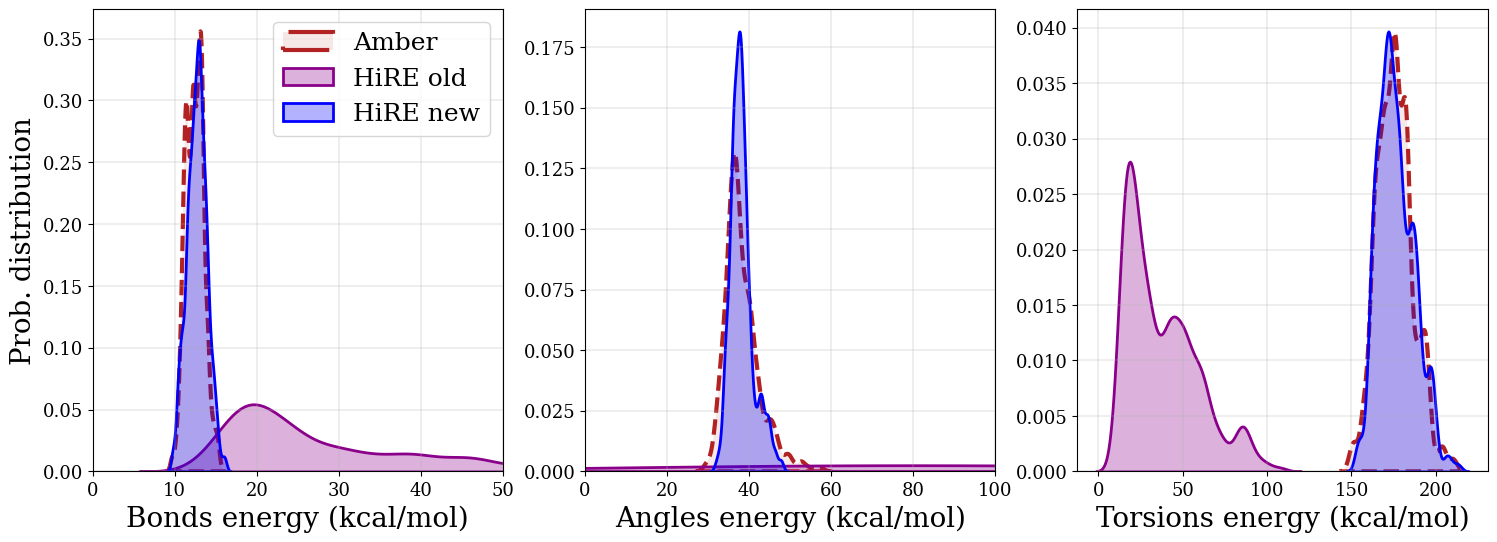

In [30]:
idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }

plot_3hist(idx_dict,energies)

In [39]:
for p in model2.parameters():
    print(p.data)

tensor([2.5078e-01, 1.4221e+00, 9.5803e-01, 1.4372e+00, 3.1685e+00, 3.0414e+00,
        2.9399e+00, 4.3877e+00, 9.1363e-01, 1.4403e+00, 1.5223e+01, 1.0000e+00,
        2.8000e+00, 2.5050e+00, 1.8260e+00, 3.9320e+00, 4.3090e+00, 4.7750e+00,
        4.5460e+00, 2.8210e+00, 3.8130e+00, 3.0100e+00, 9.0800e-01, 3.0000e+00,
        4.0000e+00, 2.2570e+00, 4.8000e-01, 5.0000e-01, 4.8864e+00, 1.0707e+01,
        1.1320e+01, 4.7431e+00, 3.5133e-01, 6.2101e-01, 6.1727e-02, 8.3912e-01,
        7.6194e-01, 6.0133e-01, 1.2000e+00, 1.5000e+00, 4.0000e-01, 1.8000e+00,
        8.0000e-01, 1.4231e+02, 1.0000e+00, 0.0000e+00, 2.8619e-02])
tensor([ 26.4737, 198.3302, 199.8809, 199.2575, 199.5909, 199.9412, 200.0606,
        199.8165, 200.0325, 199.6405, 199.5755,  40.0000,  10.0000,  10.0000,
         10.0000])
tensor([ 69.5992,  69.4485,  69.5262,  69.6653, 119.7809, 119.4121,  69.1445,
         69.0051,  68.3617,  48.1406,  68.7695,  98.8524,  80.0000])
tensor([0.6600, 1.2392, 0.2688, 0.6788, 0.8360, 0

In [52]:
model = LocalEnergy()
model.load_state_dict(torch.load('../results/NewResults/initial_values.pth'))

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
my_loss = loss_fn  # _with_grad
my_train = train  # _with_grad
my_test = test  # _with_grad

params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': True,
          'pin_memory': False}

dataset = RNASeqDataset()
tot_length = len(dataset)
test_length = int(0.2*tot_length)
train_set, test_set = random_split(dataset, [tot_length - test_length, test_length], generator=torch.Generator().manual_seed(42))
print(f'Training set: {len(train_set)} elements')
print(f'Test set: {len(test_set)} elements')
train_dataloader = DataLoader(train_set,**params)
test_dataloader = DataLoader(test_set,**params)

np.random.seed(42)
POC_coeff_init = np.random.uniform(56,84,15)
POC_eq_init = np.random.uniform(1.9305,2.3925,15)

Training set: 1308 elements
Test set: 327 elements


In [ ]:
# 15 values for couplings and equilibrium value for P-O-C angle
# lr = 1e-4, epochs = 100

epochs = 100
POC_coeff_fin = []
POC_eq_fin = []
for i in range(len(POC_coeff_init)):
    model.load_state_dict(torch.load('../results/NewResults/initial_values.pth'))
    print(model.couplings.angles[6].item(),model.equil.angles[6].item())
    sd = model.state_dict()
    sd['couplings.angles'][6] = POC_coeff_init[i]
    sd['equil.angles'][6] = POC_eq_init[i]
    model.load_state_dict(sd)
    print(model.couplings.angles[5:8],model.equil.angles[5:8])
    print(POC_coeff_init[i],POC_eq_init[i])
    for j in range(epochs):
        print(f'epoch {j+1}/{epochs} \n-------------------------')
        train_tmp = my_train(train_dataloader, model, my_loss, optimizer)
        test_tmp = my_test(test_dataloader, model, my_loss)        
    POC_coeff_fin.append(model.couplings.angles[6].item())
    POC_eq_fin.append(model.equil.angles[6].item())
    
np.save('../results/NpyFiles/POC_coeff_init.npy', POC_coeff_init)
np.save('../results/NpyFiles/POC_eq_init.npy', POC_eq_init)
np.save('../results/NpyFiles/POC_coeff_fin.npy', POC_coeff_fin)
np.save('../results/NpyFiles/POC_eq_fin.npy', POC_eq_fin)

In [56]:
print(POC_coeff_init)
print(POC_coeff_fin)

print(POC_eq_init)
print(POC_eq_fin)

[66.48712333 82.62000058 76.49583037 72.76243756 60.36852193 60.36784657
 57.62634114 80.25293208 72.83122033 75.82603218 56.57636584 83.15747586
 79.30839394 61.9454951  61.09109908]
[65.69876098632812, 81.6277847290039, 75.46281433105469, 71.67875671386719, 59.398521423339844, 59.48871994018555, 56.87437057495117, 79.26892852783203, 71.76077270507812, 74.72409057617188, 55.89199447631836, 82.32634735107422, 78.27543640136719, 61.025657653808594, 60.436187744140625]
[2.01523288 2.07105992 2.17293747 2.1300586  2.06504786 2.21317604
 1.99494616 2.06547083 2.09975917 2.14120433 2.29325129 2.02274929
 2.16807631 2.20419553 1.95196009]
[2.267799139022827, 2.2844724655151367, 2.286564826965332, 2.2890143394470215, 2.2894513607025146, 2.289987564086914, 2.290036201477051, 2.2824463844299316, 2.2906832695007324, 2.2868247032165527, 2.2840144634246826, 2.2866036891937256, 2.2886126041412354, 2.2884302139282227, 2.2863218784332275]


[[1.         0.99992605]
 [0.99992605 1.        ]]
[[1.         0.23547088]
 [0.23547088 1.        ]]


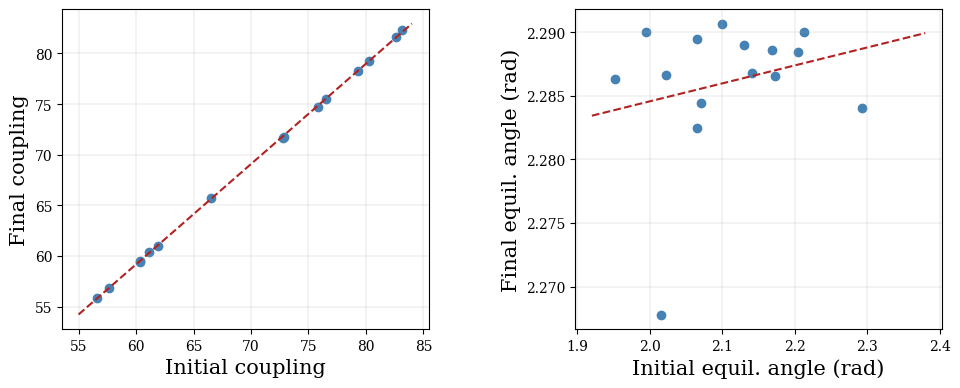

In [37]:
import scipy

POC_coeff_init = np.load('../results/NpyFiles/POC_coeff_init.npy')
POC_eq_init = np.load('../results/NpyFiles/POC_eq_init.npy')
POC_coeff_fin = np.load('../results/NpyFiles/POC_coeff_fin.npy')
POC_eq_fin = np.load('../results/NpyFiles/POC_eq_fin.npy')

res = scipy.stats.linregress(POC_coeff_init,POC_coeff_fin)
r1 = np.corrcoef(POC_coeff_init,POC_coeff_fin)
print(r1)

fig,axes = plt.subplots(1,2,figsize=(11,4))
x = np.arange(55,85)
axes[0].scatter(POC_coeff_init,POC_coeff_fin, color='steelblue')
axes[0].plot(x,res.slope*x+res.intercept, '--', color = 'firebrick')
axes[0].set_xlabel('Initial coupling', fontsize=15)
axes[0].set_ylabel('Final coupling', fontsize=15)
axes[0].grid(linewidth=0.2)

res2 = scipy.stats.linregress(POC_eq_init,POC_eq_fin)
r2 = np.corrcoef(POC_eq_init,POC_eq_fin)
print(r2)

x2 = np.arange(1.92,2.4,0.02)
axes[1].scatter(POC_eq_init,POC_eq_fin, color='steelblue')
axes[1].plot(x2,res2.slope*x2+res2.intercept, '--', color = 'firebrick')
axes[1].set_xlabel('Initial equil. angle (rad)', fontsize=15)
axes[1].set_ylabel('Final equil. angle (rad)', fontsize=15)
axes[1].grid(linewidth=0.2)

# fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.savefig('../Images/POC_angle.png', bbox_inches='tight', dpi=100)

# plt.scatter(POC_coeff_fin,POC_eq_fin)
# plt.scatter(POC_coeff_init,POC_eq_init)